# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [28]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random
from sklearn.metrics import accuracy_score

Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [29]:
class Perceptron:
    def __init__(self, iterations=100):
        self.w = None
        self.iterations = iterations
        
    def h(self, x, w):
        return np.sign(x@w.T)

    def fit(self, X, y):
        X = np.column_stack([[1 for i in range(len(X))],X])
        len_X = X.shape[0]
        y[y == 0] = -1
        self.w = np.array([random.random() for i in range(X.shape[1])]) 
        
        for i in range(self.iterations):
            for index in range(len_X):
                if self.h(X[index], self.w) != y[index]: 
                    self.w = self.w + y[index]*X[index].T 


    def predict(self, X):
        X = np.column_stack([[1 for i in range(len(X))],X])
        pred = np.array([])
        for el in X:
            pred = np.append(pred, self.h(el, self.w))
        return pred
                

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [30]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

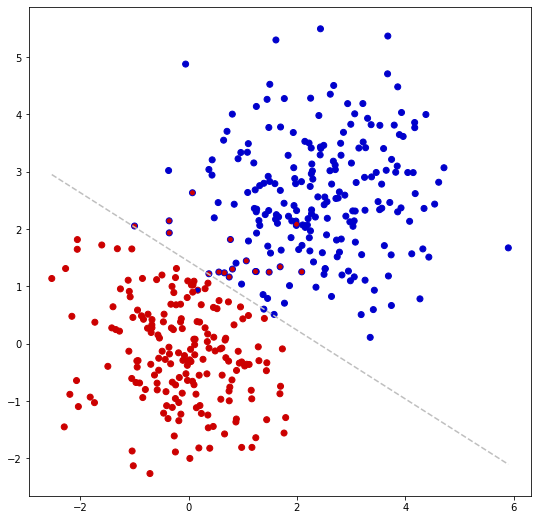

In [31]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

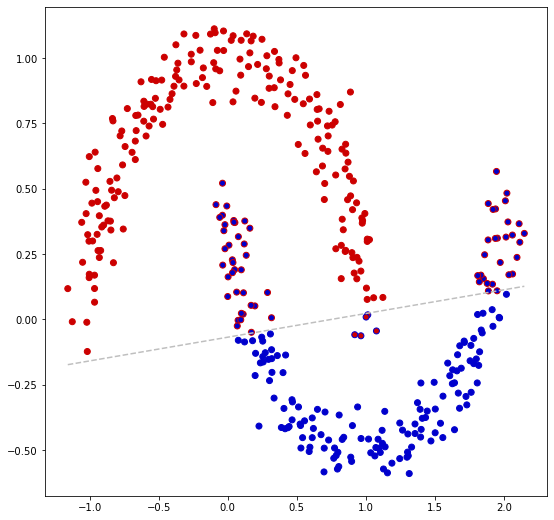

In [32]:
X, true_labels = make_moons(400, noise=0.075)
#true_labels[true_labels == 0] = -1
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [33]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])

In [34]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.w = None
        self.iterations = iterations
        
    def h(self, x, w):
        return np.sign(x@w.T)
    

    def fit(self, X, y):
        X = np.column_stack([[1 for i in range(len(X))],X])
        y[y == 0] = -1
        len_X = X.shape[0]
        main_error = np.inf
        self.w = np.array([random.random() for i in range(X.shape[1])])
        w = self.w.copy()
        for i in range(self.iterations):
            err = 0
            for index in range(len_X):
                if self.h(X[index], w) != y[index]:
                    w += y[index]*X[index].T
                    err += 1
            if err < main_error:
                main_error = err
                self.w = w.copy()


    def predict(self, X):
        X = np.column_stack([[1 for i in range(len(X))],X])
        pred = np.array([])
        for el in X:
            pred = np.append(pred, self.h(el, self.w))
        return pred


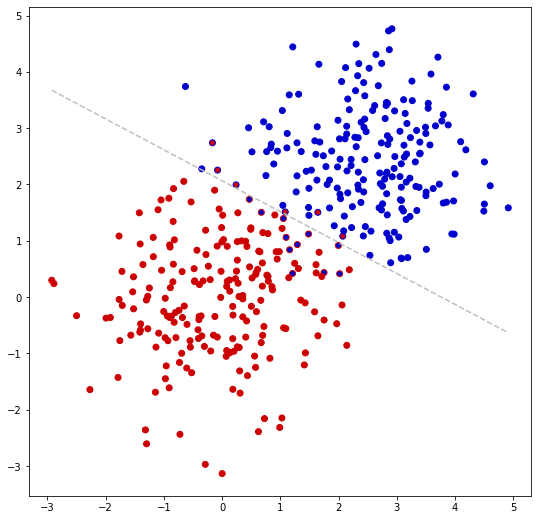

In [35]:
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

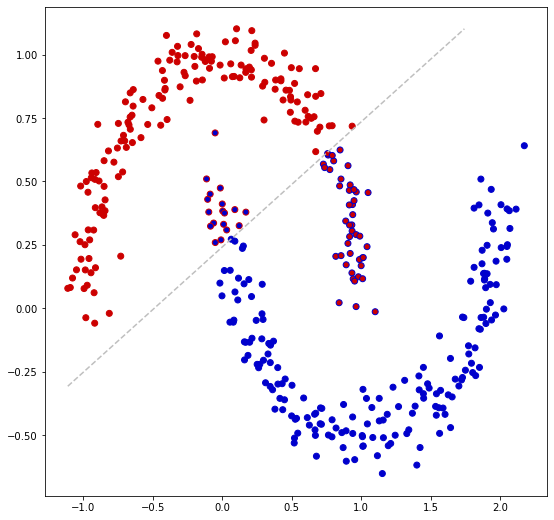

In [36]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [57]:
def transform_images(images):
    #TODO: TOUR CODE HERE
    return np.array([[np.sum(i[0, :]), np.sum(i[:, 3])] for i in images])

def get_digits(train_image_ids, test_image_ids):
    data = datasets.load_digits()
    images_train, labels_train = data.images[train_image_ids['ImageId'].values], data.target[train_image_ids['ImageId'].values]
    images_test, labels_test = data.images[test_image_ids['ImageId'].values], data.target[test_image_ids['ImageId'].values]
    return images_train, labels_train, images_test, labels_test

def get_digits_by_mask(images, labels, y0, y1):
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    return images, labels

def get_x_y(train_image_ids, test_image_ids, y0=1, y1=5):
    X_train, y_train, X_test, y_test = get_digits(train_image_ids, test_image_ids)

    X_train, y_train = get_digits_by_mask(X_train, y_train, y0, y1)
    X_train = transform_images(X_train)

    X_test, y_test = get_digits_by_mask(X_test, y_test, y0, y1)
    X_test = transform_images(X_test)

    return X_train, y_train, X_test, y_test

Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [58]:
train_ids, test_ids = pd.read_csv("/Users/vasilijdronov/Machine learning/x_digits_train.csv"), pd.read_csv("/Users/vasilijdronov/Machine learning/x_digits_test.csv")
X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids)

In [59]:
y_train[y_train == 1] = -1
y_train[y_train == 5] = 1
y_test[y_test == 1] = -1
y_test[y_test == 5] = 1

In [60]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
pred1 = c.predict(X_test)
print("Accuracy:", np.mean(pred1 == y_test))

Accuracy: 0.9726027397260274


In [61]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
pred2 = c.predict(X_test)
print("Accuracy:", np.mean(pred2 == y_test))

Accuracy: 0.958904109589041


In [62]:
pred = pred1.copy()

In [63]:
pred[pred == 1.] = 5
pred[pred == -1.] = 1


In [64]:
pred = list(pred)

In [65]:
pred = [int(i) for i in pred]


In [66]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test_ids['Id']
submission["Expected"] = pred
submission.to_csv('submission.csv', index=False)

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [67]:
train_ids, test_ids = pd.read_csv("/Users/vasilijdronov/Machine learning/x_digits_train.csv"), pd.read_csv("/Users/vasilijdronov/Machine learning/x_digits_test.csv")

In [68]:
for i in range(1467, 1600):
    train_ids = train_ids.append({'Id':i, 'ImageId':random.randint(1,1000)}, ignore_index = True)
for i in range(73, 140):
    test_ids = test_ids.append({'Id':i, 'ImageId':random.randint(1,1000)}, ignore_index = True)

In [69]:
from sklearn.datasets import load_digits
def transform_images(images):
    #TODO: TOUR CODE HERE
    return np.array([[np.sum(i[0, :]), np.sum(i[1, :])] for i in images])

def get_digits(train_image_ids, test_image_ids):
    data = datasets.load_digits()
    images_train, labels_train = data.images[train_image_ids['ImageId'].values], data.target[train_image_ids['ImageId'].values]
    images_test, labels_test = data.images[test_image_ids['ImageId'].values], data.target[test_image_ids['ImageId'].values]
    return images_train, labels_train, images_test, labels_test

def get_digits_by_mask(images, labels, y0, y1):
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)

    return images, labels

def get_x_y(train_image_ids, test_image_ids, y0=1, y1=5):
    X_train, y_train, X_test, y_test = get_digits(train_image_ids, test_image_ids)

    X_train, y_train = get_digits_by_mask(X_train, y_train, y0, y1)
    X_train = transform_images(X_train)

    X_test, y_test = get_digits_by_mask(X_test, y_test, y0, y1)
    X_test = transform_images(X_test)

    return X_train, y_train, X_test, y_test

In [70]:

accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    if X_train == [] or X_test == []:
        break
    c = Perceptron(iterations=20000)
    
    values = list(set(y_train))
    y_train[y_train == int(values[0])] = -1
    y_train[y_train == int(values[1])] = 1
        
        
    c.fit(X_train, y_train)
    pred = c.predict(X_test)
    pred = list([int(i) for i in pred])
    
    
    values = list(set(y_test))
    y_test[y_test == int(values[0])] = -1
    y_test[y_test == int(values[1])] = 1
    
    y_test = list(y_test)
    accs.append(np.mean(np.array(pred) == np.array(y_test)))

print("Mean accuracy:", np.mean(accs))

/Users/vasilijdronov/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


pred:  [1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1]
test:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1]
[0.43636363636363634]
pred:  [1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1]
test:  [1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1]
[0.43636363636363634, 0.6]
pred:  [-1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1]
test:  [-1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1]
[0.43636363636363634, 0.6, 0.9285714285714286]
pred:  [-1, -1, -1, 1, -1, -1, -1, 1, 1, -1]
test:  [-1, -1, -1, 1, -1, -1, -1, 1, -1, -1]
[0.43636363636363634, 0.6, 0.9285714285714286, 0.9]
pred:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1,

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    pred = c.predict(X_test)
    pred[pred == -1] = 0
    pred = list([int(i) for i in pred])
    y_test = list(y_test)
    accs.append(np.mean(pred == y_test))
print("Mean accuracy:", np.mean(accs))